## READ CSV FILES

In [1]:
import pandas as pd

## read crystal- and dco- timestamped data
columns = ['Timestamp', 'X', 'Y', 'Z'];
sensor1_df = pd.read_csv('Data/Crystal_accel_COM9_4MHz_2.csv', names=columns);
sensor1 = sensor1_df.as_matrix();

sensor2_df = pd.read_csv('Data/DCO_accel_COM6_2MHz_2.csv', names=columns);
sensor2 = sensor2_df.as_matrix();


## COMPENSATE DIFFERENT SIZES

In [4]:
# crystal file likely to be longer than DCO file, due to different clock frequencies
# (Crystal: 4MHz, DCO: 2MHz)
diff = abs(len(sensor1) - len(sensor2));

if(len(sensor1) > len(sensor2)):
    #crystal = crystal[diff:-1];
    sensor1 = sensor1[0:-diff];
else:
    #dco = dco[diff:-1];
    sensor2 = sensor2[0:-diff];

## Plot the data (Prelim)

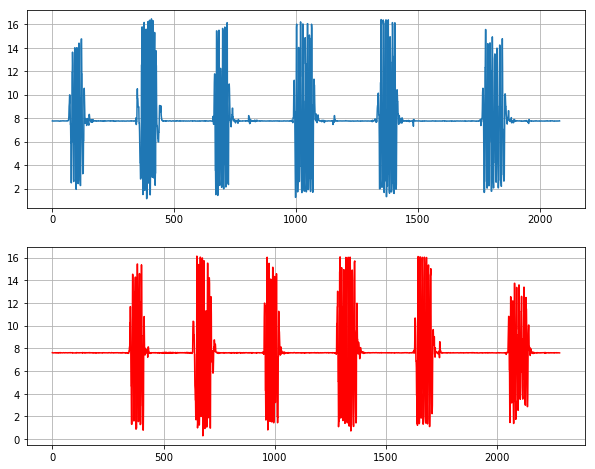

In [28]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# Set default plot size
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

sensor1_mag = np.square(sensor1[:,1]) + np.square(sensor1[:,2]) + np.square(sensor1[:,3]);
sensor1_mag = np.sqrt(sensor1_mag);

sensor2_mag = np.square(sensor2[:,1]) + np.square(sensor2[:,2]) + np.square(sensor2[:,3]);
sensor2_mag = np.sqrt(sensor2_mag);

# Compute elapsed times
ctime = sensor1[:,0];
ctime = ctime - ctime[0];

dtime = sensor2[:,0];
dtime = dtime - dtime[0];

# cut out extra stuff before where nothing happened
#sensor1_mag = sensor1_mag[6200:-1]
#ctime = ctime[6200:-1]
sensor2_mag = sensor2_mag[6000:-1]
dtime = dtime[6000:-1]

# Plot both accelerometers
# Plot both accelerometers
f, axes = plt.subplots(2);
        
ax1 = axes[0];
ax2 = axes[1];

#plt.style.use('classic')

ax1.plot(sensor1_mag);
ax1.grid();

ax2.plot(sensor2_mag,color='r');
ax2.grid();

plt.show();

# Template version

## Extract a single template

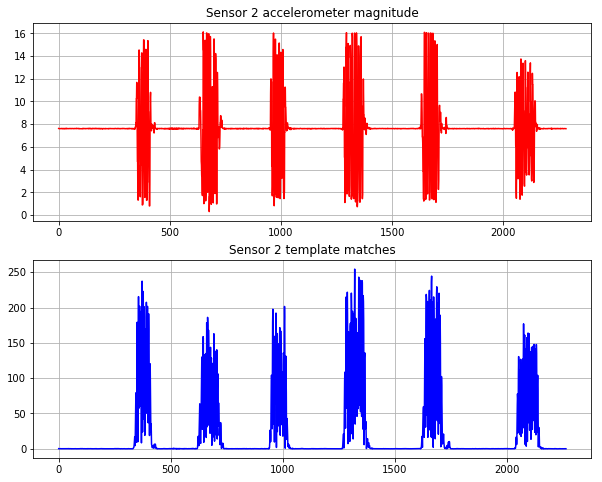

In [307]:
import cv2
import mpld3
mpld3.enable_notebook();
## Template can be just the first handshake on sensor1 
template = sensor1_mag[120:140];
template2 = sensor1_mag[65:140];
f, axes = plt.subplots(2);
        
ax1 = axes[0];
ax2 = axes[1];

ax1.plot(abs(sensor2_mag), 'r');
ax1.set_title("Sensor 2 accelerometer magnitude")
ax1.grid()
#plt.show()
## Find the observations on sensor 2 
res = cv2.matchTemplate(sensor2_mag.astype(np.float32),template.astype(np.float32),4)

# Pad the arrays to compensate for some artificial delays created
#res = np.lib.pad(res, diff, 'edge')
res = abs(res)
ax2.plot(res, 'b')
ax2.set_title("Sensor 2 template matches")
ax2.grid()

plt.show()

min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)


## Match the templates with the correct time on Sensor 2

In [283]:
observations_sensor2 = [];
collecting = False;
thresh = 45;
count = 0;
sensor2_mag = abs(sensor2_mag)
for i in range(0, len(res)):
    if(res[i][0] > 5):
        if(collecting == False):
            collect = [];
            collecting = True;
            count = 0;
            
        count = count + 1;
        collect.append(sensor2_mag[i])

    elif(res[i][0] < 5 and collecting == True):
        if(count >= thresh):
            observations_sensor2.append(collect)
        collect = [];
        collecting = False;
        count = 0;
print("Found: " + str(len(observations_sensor2)) + " observations.")
        

Found: 6 observations.


## Match usingMutual Information

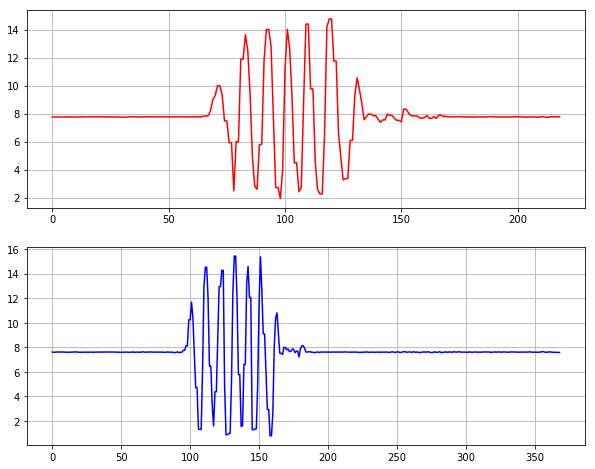

0.846123685865
0.686983865884
1.0
1.0
1.0
1.0
1.0
Missed one observation!


In [321]:
from sklearn.metrics.cluster import normalized_mutual_info_score

# We now have all the observations in sensor 2 by using template matching. 
# Now we must find the signals in sensor 1
obs_time = dtime[np.where(sensor2_mag == observations_sensor2[0][0])[0][0]];
sens_time = ctime[0];
ppm = 2;
window_size = int((obs_time - sens_time) * (ppm/1000000))
f, axes = plt.subplots(2);
        
ax1 = axes[0];
ax2 = axes[1];

ax1.plot(sensor1_mag[0:window_size-150], 'r');
ax1.grid(True);

ax2.plot(sensor2_mag[250:window_size+250], 'b')
ax2.grid(True);
plt.show()
print(normalized_mutual_info_score(sensor1_mag[0:window_size], sensor2_mag[250:window_size+250]))
# Get mutual info score with sensor1 data
for i in range(0, len(sensor1_mag), window_size):
    print(normalized_mutual_info_score(sensor1_mag[i:window_size], sensor2_mag[i:window_size]))

print("Missed one observation!")